# 01_data_exploration_and_feature_engineering — FINAL

**Purpose:** Complete EDA and provider-level feature engineering for the Healthcare Provider Fraud Detection project. This notebook includes dataset relationships, data-quality checks, exploratory analysis, fraud vs. non-fraud comparisons, a recommended aggregation strategy, and export of provider-level features.

**Notes:** Update file paths if your CSVs are stored in a different location.

## 0. Environment & Instructions
- This notebook expects the CSV files in the same folder or provide full paths for these filenames:
  - `Train_Beneficiarydata.csv`
  - `Train_Inpatientdata.csv`
  - `Train_Outpatientdata.csv`
  - `Train_labels.csv`
- The notebook uses pandas and matplotlib for plotting.

## 1. Imports

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [135]:
path = '../data/'

files = {
    'benef': path + 'Train_Beneficiarydata-1542865627584.csv',
    'inpat': path + 'Train_Inpatientdata-1542865627584.csv',
    'outpat': path + 'Train_Outpatientdata-1542865627584.csv',
    'labels': path + 'Train-1542865627584.csv'
}
for k,v in files.items():
    print(k, '->', v, 'exists=', os.path.exists(v))

benef = pd.read_csv(files['benef'])
inpat = pd.read_csv(files['inpat'])
outpat = pd.read_csv(files['outpat'])
labels = pd.read_csv(files['labels'])

print('Loaded shapes:')
print('benef', benef.shape)
print('inpat', inpat.shape)
print('outpat', outpat.shape)
print('labels', labels.shape)

benef -> ../data/Train_Beneficiarydata-1542865627584.csv exists= True
inpat -> ../data/Train_Inpatientdata-1542865627584.csv exists= True
outpat -> ../data/Train_Outpatientdata-1542865627584.csv exists= True
labels -> ../data/Train-1542865627584.csv exists= True
Loaded shapes:
benef (138556, 25)
inpat (40474, 30)
outpat (517737, 27)
labels (5410, 2)
Loaded shapes:
benef (138556, 25)
inpat (40474, 30)
outpat (517737, 27)
labels (5410, 2)


## 3. Relationship & Granularity
**Relationships (join keys):**
- `BeneID` links beneficiary table to inpatient & outpatient claim tables.
- `Provider` in claim tables links to labels table which has one row per provider.

**Granularity:**
- Beneficiary table: one row per patient.
- Claims: one row per claim event.
- Labels: one row per provider.

## 4. Basic data quality checks

In [136]:
def basic_checks(df, name):
    print(f'\n---- {name} ----')
    print('Shape:', df.shape)
    print('Duplicates:', df.duplicated().sum())
    print('\nMissing Values (Top 20):')
    missing = df.isna().sum().sort_values(ascending=False).head(20)
    missing_pct = (missing / len(df) * 100).round(2)
    print(pd.DataFrame({'Count': missing, 'Percent': missing_pct}))
    
    # Separate numeric and categorical
    numeric_cols = df.select_dtypes(include=[np.number])
    if not numeric_cols.empty:
        print('\n--- Numeric Columns ---')
        display(numeric_cols.describe().T)
    else:
        print('\n--- No Numeric Columns ---')
    
    cat_cols = df.select_dtypes(exclude=[np.number])
    if not cat_cols.empty:
        print('\n--- Categorical Columns ---')
        display(cat_cols.describe().T)
    else:
        print('\n--- No Categorical Columns ---')

basic_checks(benef, 'Beneficiary')
basic_checks(inpat, 'Inpatient')
basic_checks(outpat, 'Outpatient')
basic_checks(labels, 'Labels')


---- Beneficiary ----
Shape: (138556, 25)
Duplicates: 0

Missing Values (Top 20):
                                  Count  Percent
DOD                              137135    98.97
BeneID                                0     0.00
DOB                                   0     0.00
Gender                                0     0.00
Race                                  0     0.00
RenalDiseaseIndicator                 0     0.00
State                                 0     0.00
County                                0     0.00
NoOfMonths_PartACov                   0     0.00
NoOfMonths_PartBCov                   0     0.00
ChronicCond_Alzheimer                 0     0.00
ChronicCond_Heartfailure              0     0.00
ChronicCond_KidneyDisease             0     0.00
ChronicCond_Cancer                    0     0.00
ChronicCond_ObstrPulmonary            0     0.00
ChronicCond_Depression                0     0.00
ChronicCond_Diabetes                  0     0.00
ChronicCond_IschemicHeart          

,count,mean,std,min,25%,50%,75%,max
Gender,138556.0,1.570932,0.494945,1.0,1.0,2.0,2.0,2.0
Race,138556.0,1.254511,0.717007,1.0,1.0,1.0,1.0,5.0
State,138556.0,25.666734,15.223443,1.0,11.0,25.0,39.0,54.0
County,138556.0,374.424745,266.277581,0.0,141.0,340.0,570.0,999.0
NoOfMonths_PartACov,138556.0,11.907727,1.032332,0.0,12.0,12.0,12.0,12.0
NoOfMonths_PartBCov,138556.0,11.910145,0.936893,0.0,12.0,12.0,12.0,12.0
ChronicCond_Alzheimer,138556.0,1.667817,0.470998,1.0,1.0,2.0,2.0,2.0
ChronicCond_Heartfailure,138556.0,1.506322,0.499962,1.0,1.0,2.0,2.0,2.0
ChronicCond_KidneyDisease,138556.0,1.687643,0.463456,1.0,1.0,2.0,2.0,2.0
ChronicCond_Cancer,138556.0,1.880041,0.324914,1.0,2.0,2.0,2.0,2.0



--- Categorical Columns ---


,count,unique,top,freq
BeneID,138556,138556,BENE11001,1
DOB,138556,900,1939-10-01,540
DOD,1421,11,2009-12-01,182
RenalDiseaseIndicator,138556,2,0,118978



---- Inpatient ----
Shape: (40474, 30)
Duplicates: 0

Missing Values (Top 20):
                     Count  Percent
ClmProcedureCode_6   40474   100.00
ClmProcedureCode_5   40465    99.98
ClmProcedureCode_4   40358    99.71
ClmProcedureCode_3   39509    97.62
ClmDiagnosisCode_10  36547    90.30
OtherPhysician       35784    88.41
ClmProcedureCode_2   35020    86.52
ClmProcedureCode_1   17326    42.81
OperatingPhysician   16644    41.12
ClmDiagnosisCode_9   13497    33.35
ClmDiagnosisCode_8    9942    24.56
ClmDiagnosisCode_7    7258    17.93
ClmDiagnosisCode_6    4838    11.95
ClmDiagnosisCode_5    2894     7.15
ClmDiagnosisCode_4    1534     3.79
DeductibleAmtPaid      899     2.22
ClmDiagnosisCode_3     676     1.67
ClmDiagnosisCode_2     226     0.56
AttendingPhysician     112     0.28
DischargeDt              0     0.00

--- Numeric Columns ---


,count,mean,std,min,25%,50%,75%,max
InscClaimAmtReimbursed,40474.0,10087.884074,10303.099402,0.0,4000.00,7000.0,12000.00,125000.0
DeductibleAmtPaid,39575.0,1068.000000,0.000000,1068.0,1068.00,1068.0,1068.00,1068.0
ClmProcedureCode_1,23148.0,5894.611759,3049.304400,11.0,3848.00,5369.0,8666.25,9999.0
ClmProcedureCode_2,5454.0,4103.738174,2028.182156,42.0,2724.00,4019.0,4439.00,9999.0
ClmProcedureCode_3,965.0,4226.355440,2282.761581,42.0,2724.00,4019.0,5185.00,9999.0
ClmProcedureCode_4,116.0,4070.172414,1994.409802,42.0,2758.75,4019.0,4439.00,9986.0
ClmProcedureCode_5,9.0,5269.444444,2780.071632,2724.0,4139.00,4139.0,5185.00,9982.0
ClmProcedureCode_6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



--- Categorical Columns ---


,count,unique,top,freq
BeneID,40474,31289,BENE134170,8
ClaimID,40474,40474,CLM46614,1
ClaimStartDt,40474,398,2009-02-10,145
ClaimEndDt,40474,365,2009-02-11,153
Provider,40474,2092,PRV52019,516
AttendingPhysician,40362,11604,PHY422134,386
OperatingPhysician,23830,8287,PHY429430,225
OtherPhysician,4690,2877,PHY416093,81
AdmissionDt,40474,398,2009-02-10,144
ClmAdmitDiagnosisCode,40474,1928,78650,1731



---- Outpatient ----
Shape: (517737, 27)
Duplicates: 0

Missing Values (Top 20):
Duplicates: 0

Missing Values (Top 20):
                        Count  Percent
ClmProcedureCode_5     517737   100.00
ClmProcedureCode_6     517737   100.00
ClmProcedureCode_4     517735   100.00
ClmProcedureCode_3     517733   100.00
ClmProcedureCode_2     517701    99.99
ClmProcedureCode_1     517575    99.97
ClmDiagnosisCode_10    516654    99.79
ClmDiagnosisCode_9     502899    97.13
ClmDiagnosisCode_8     494825    95.57
ClmDiagnosisCode_7     484776    93.63
ClmDiagnosisCode_6     468981    90.58
ClmDiagnosisCode_5     443393    85.64
OperatingPhysician     427120    82.50
ClmAdmitDiagnosisCode  412312    79.64
ClmDiagnosisCode_4     392141    75.74
OtherPhysician         322691    62.33
ClmDiagnosisCode_3     314480    60.74
ClmDiagnosisCode_2     195380    37.74
ClmDiagnosisCode_1      10453     2.02
AttendingPhysician       1396     0.27

--- Numeric Columns ---
                        Count  Per

,count,mean,std,min,25%,50%,75%,max
InscClaimAmtReimbursed,517737.0,286.334799,694.034343,0.0,40.00,80.0,200.00,102500.0
ClmProcedureCode_1,162.0,6116.611111,3217.719258,51.0,3893.00,5244.5,9421.50,9999.0
ClmProcedureCode_2,36.0,4503.277778,2504.015000,412.0,2724.00,4019.0,5849.00,9982.0
ClmProcedureCode_3,4.0,2959.000000,1863.455393,412.0,2146.00,3511.5,4324.50,4401.0
ClmProcedureCode_4,2.0,4075.500000,5323.806956,311.0,2193.25,4075.5,5957.75,7840.0
ClmProcedureCode_5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ClmProcedureCode_6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DeductibleAmtPaid,517737.0,2.779233,15.785839,0.0,0.00,0.0,0.00,897.0



--- Categorical Columns ---


,count,unique,top,freq
BeneID,517737,133980,BENE118316,29
ClaimID,517737,517737,CLM624349,1
ClaimStartDt,517737,385,2009-03-03,1574
ClaimEndDt,517737,366,2009-03-03,1563
Provider,517737,5012,PRV51459,8240
AttendingPhysician,516341,74109,PHY330576,2534
OperatingPhysician,90617,28532,PHY330576,424
OtherPhysician,195046,44388,PHY412132,1247
ClmDiagnosisCode_1,507284,10354,4019,13803
ClmDiagnosisCode_2,322357,5056,4019,19894



---- Labels ----
Shape: (5410, 2)
Duplicates: 0

Missing Values (Top 20):
                Count  Percent
Provider            0      0.0
PotentialFraud      0      0.0

--- No Numeric Columns ---

--- Categorical Columns ---


,count,unique,top,freq
Provider,5410,5410,PRV51001,1
PotentialFraud,5410,2,No,4904


### 4.1 Date parsing and logical checks

In [137]:
from dateutil import parser
for df,name in [(benef,'benef'),(inpat,'inpat'),(outpat,'outpat')]:
    print('\nDataset', name)
    for col in df.columns:
        sample = df[col].dropna().astype(str).head(5).tolist()
        if any(['-' in s or '/' in s or ':' in s for s in sample]):
            print(' candidate date-like:', col)

# Try parsing common date columns
for col in ['DOB','DOD','ClaimDate','ClaimStartDt','ClaimEndDt','ServiceDate']:
    if col in benef.columns:
        benef[col] = pd.to_datetime(benef[col], errors='coerce')
        print('benef parsed', col, 'nulls:', benef[col].isna().sum())
    if col in inpat.columns:
        inpat[col] = pd.to_datetime(inpat[col], errors='coerce')
        print('inpat parsed', col, 'nulls:', inpat[col].isna().sum())
    if col in outpat.columns:
        outpat[col] = pd.to_datetime(outpat[col], errors='coerce')
        print('outpat parsed', col, 'nulls:', outpat[col].isna().sum())

# Example logical check for claims after death
if 'DOD' in benef.columns and 'ClaimDate' in inpat.columns:
    dead = benef[['BeneID','DOD']].dropna()
    merged = inpat.merge(dead, on='BeneID', how='inner')
    after = merged[merged['ClaimDate'] > merged['DOD']]
    print('inpatient claims after death:', after.shape[0])
if 'DOD' in benef.columns and 'ClaimDate' in outpat.columns:
    dead = benef[['BeneID','DOD']].dropna()
    merged = outpat.merge(dead, on='BeneID', how='inner')
    after = merged[merged['ClaimDate'] > merged['DOD']]
    print('outpatient claims after death:', after.shape[0])


Dataset benef
 candidate date-like: DOB
 candidate date-like: DOD

Dataset inpat
 candidate date-like: ClaimStartDt
 candidate date-like: ClaimEndDt
 candidate date-like: AdmissionDt
 candidate date-like: DischargeDt

Dataset outpat
 candidate date-like: ClaimStartDt
 candidate date-like: ClaimEndDt

Dataset inpat
 candidate date-like: ClaimStartDt
 candidate date-like: ClaimEndDt
 candidate date-like: AdmissionDt
 candidate date-like: DischargeDt

Dataset outpat
 candidate date-like: ClaimStartDt
 candidate date-like: ClaimEndDt
benef parsed DOB nulls: 0
benef parsed DOD nulls: 137135
inpat parsed ClaimStartDt nulls: 0
outpat parsed ClaimStartDt nulls: 0
inpat parsed ClaimEndDt nulls: 0
outpat parsed ClaimEndDt nulls: 0
benef parsed DOB nulls: 0
benef parsed DOD nulls: 137135
inpat parsed ClaimStartDt nulls: 0
outpat parsed ClaimStartDt nulls: 0
inpat parsed ClaimEndDt nulls: 0
outpat parsed ClaimEndDt nulls: 0


## 5. Exploratory Analysis — Beneficiaries

age stats:


count    138556.000000
mean         89.128663
std          12.724354
min          42.000000
25%          84.000000
50%          90.000000
75%          97.000000
max         116.000000
Name: age, dtype: float64

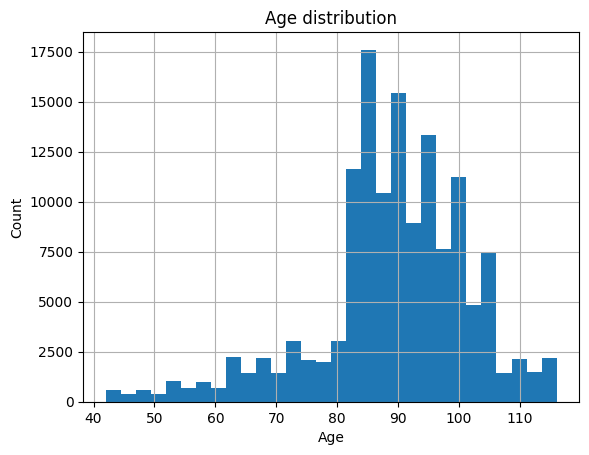

In [138]:
if 'DOB' in benef.columns:
    # Ensure DOB is datetime type for age calculation
    benef['DOB'] = pd.to_datetime(benef['DOB'], errors='coerce')
    today = pd.Timestamp('today')
    benef['age'] = (today - benef['DOB']).dt.days // 365
    print('age stats:')
    display(benef['age'].describe())
    plt.figure()
    benef['age'].dropna().hist(bins=30)
    plt.title('Age distribution')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.show()

In [139]:
import pandas as pd

# Ensure benef DataFrame exists and has a 'DOB' column
# (Assuming 'benef' is already loaded from previous cells)

# Define 'today' if not already defined
today = pd.Timestamp('today')

# Convert 'DOB' to datetime, handling errors by coercing invalid dates to NaT
benef['DOB'] = pd.to_datetime(benef['DOB'], errors='coerce')

# Calculate age
benef['age'] = (today - benef['DOB']).dt.days // 365

print('Age column created/updated.')
display(benef[['BeneID', 'DOB', 'age']].head())

Age column created/updated.


,BeneID,DOB,age
0,BENE11001,1943-01-01,82
1,BENE11002,1936-09-01,89
2,BENE11003,1936-08-01,89
3,BENE11004,1922-07-01,103
4,BENE11005,1935-09-01,90


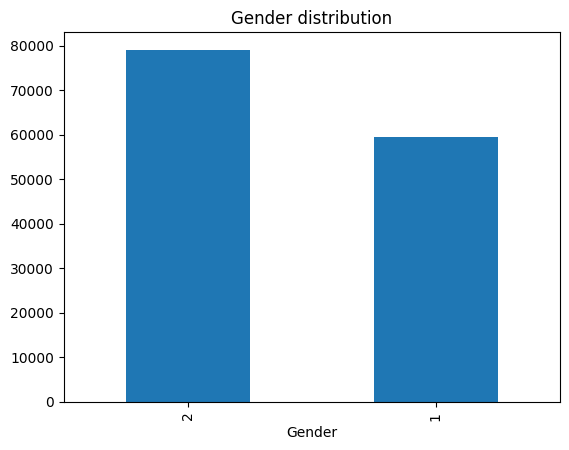

In [140]:
if 'Gender' in benef.columns:
    plt.figure()
    benef['Gender'].value_counts(dropna=False).plot(kind='bar')
    plt.title('Gender distribution')
    plt.show()

chronic-like columns: ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']


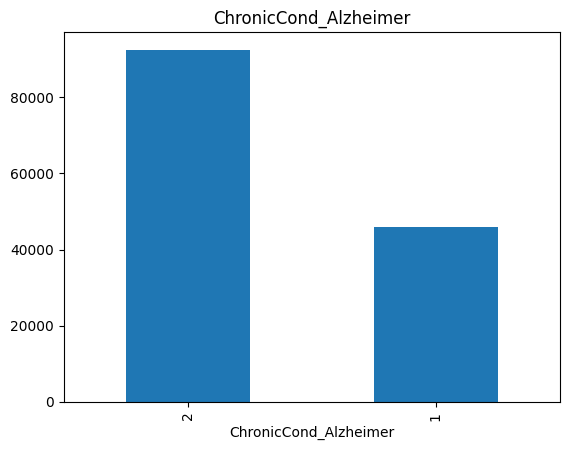

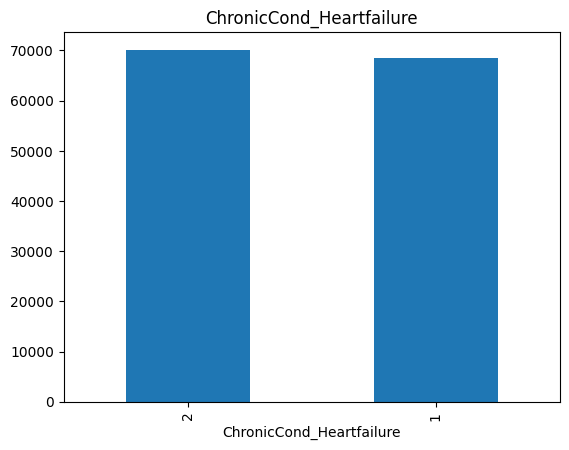

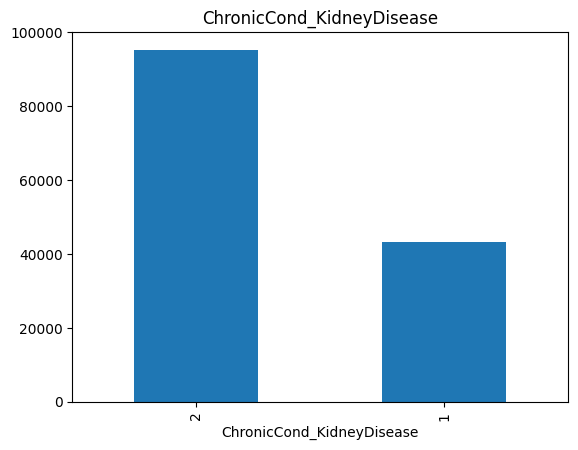

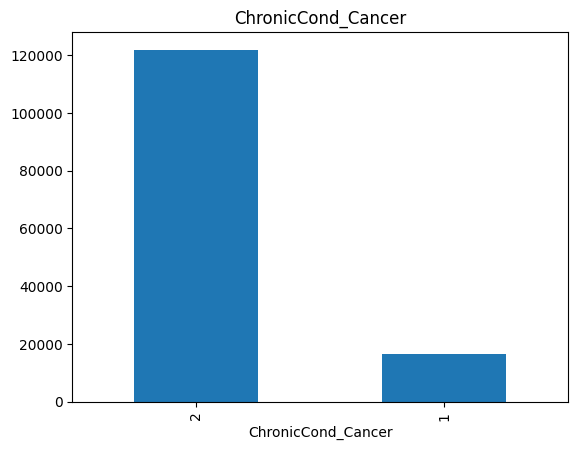

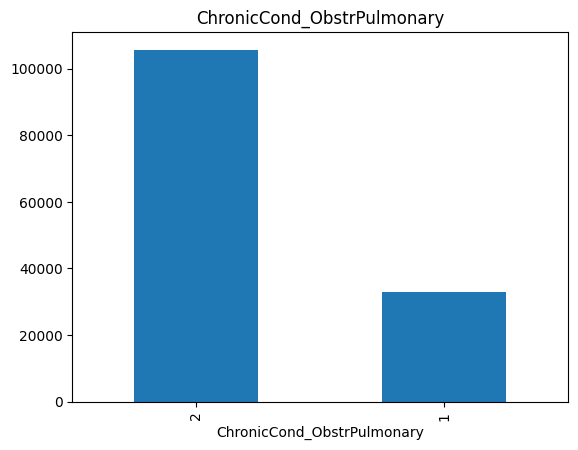

In [141]:
chronic_cols = [c for c in benef.columns if 'Chronic' in c or 'chronic' in c or 'Condition' in c]
print('chronic-like columns:', chronic_cols)
for c in chronic_cols[:5]:
    plt.figure()
    benef[c].value_counts(dropna=False).head(20).plot(kind='bar')
    plt.title(c)
    plt.show()

## 6. Exploratory Analysis — Claims

inpatient amount-like: ['InscClaimAmtReimbursed', 'DeductibleAmtPaid']


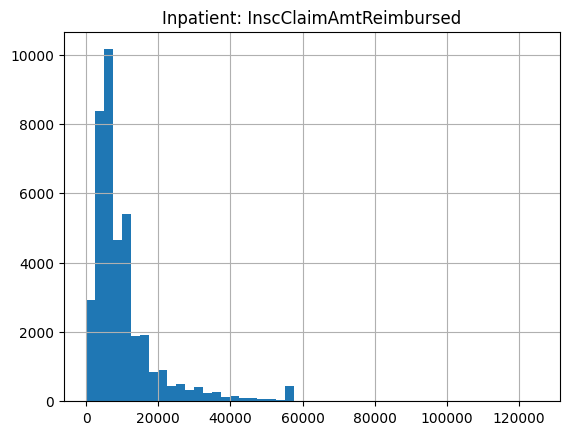

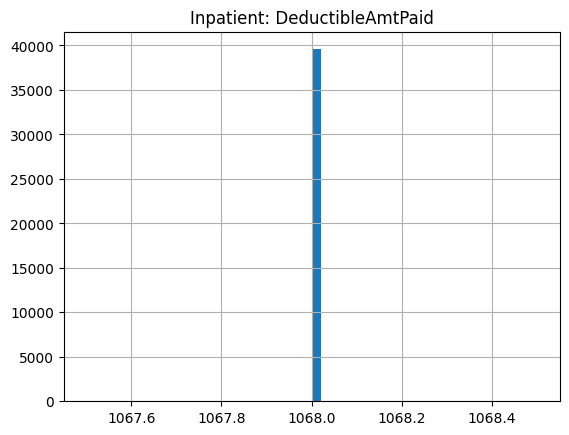

outpatient amount-like: ['InscClaimAmtReimbursed', 'DeductibleAmtPaid']


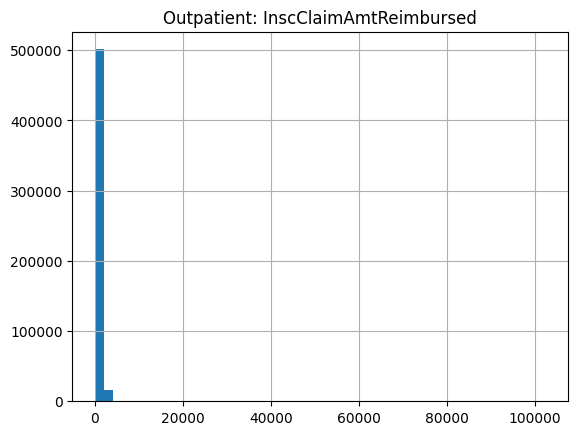

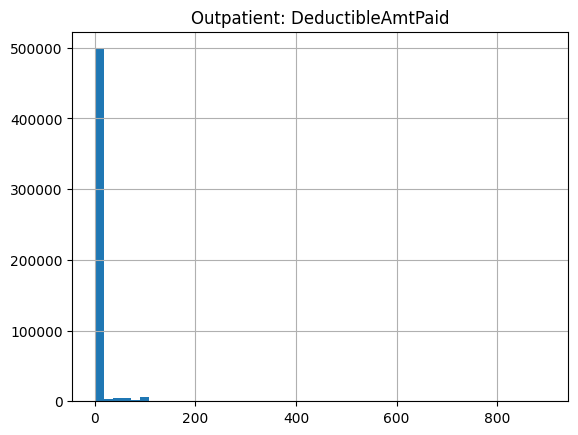

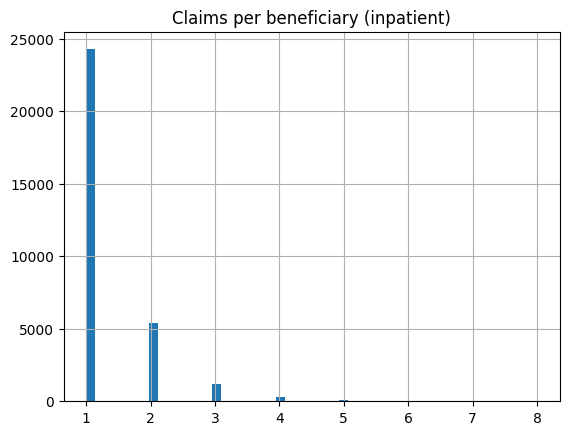

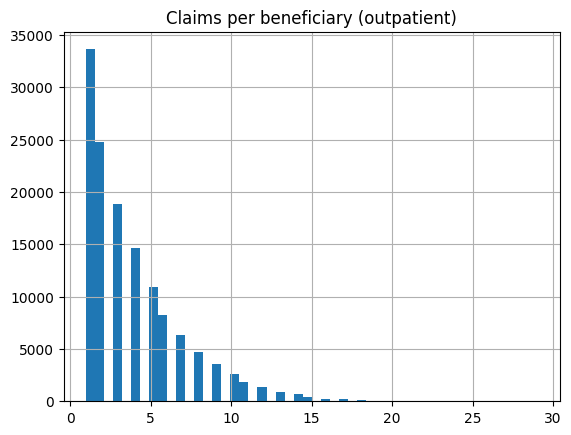

inpatient top 10 providers:


Provider
PRV52019    516
PRV55462    386
PRV54367    322
PRV53706    282
PRV55209    275
PRV56560    248
PRV54742    231
PRV55230    225
PRV52340    224
PRV51501    223
dtype: int64

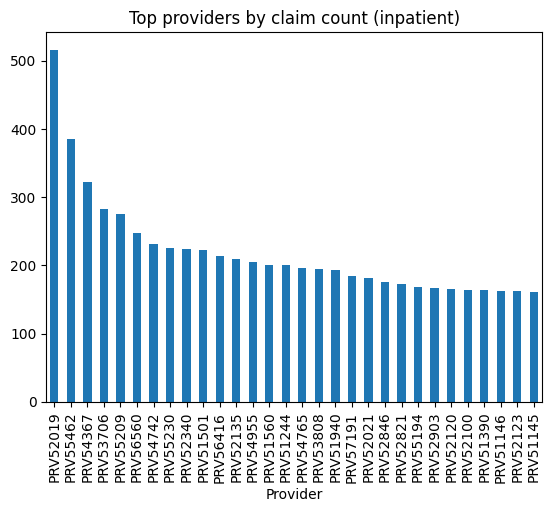

outpatient top 10 providers:


Provider
PRV51459    8240
PRV53797    4739
PRV51574    4444
PRV53918    3588
PRV54895    3433
PRV55215    3250
PRV56011    2833
PRV52064    2806
PRV55004    2396
PRV57306    2315
dtype: int64

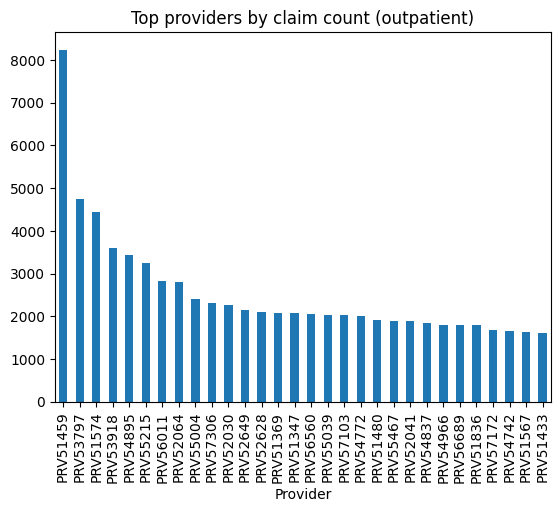

In [142]:
amt_cols = [c for c in inpat.columns if 'Amt' in c or 'Reimb' in c or 'Amount' in c]
print('inpatient amount-like:', amt_cols)
for c in amt_cols[:5]:
    plt.figure()
    inpat[c].dropna().astype(float).hist(bins=50)
    plt.title('Inpatient: '+c)
    plt.show()

amt_cols_out = [c for c in outpat.columns if 'Amt' in c or 'Reimb' in c or 'Amount' in c]
print('outpatient amount-like:', amt_cols_out)
for c in amt_cols_out[:5]:
    plt.figure()
    outpat[c].dropna().astype(float).hist(bins=50)
    plt.title('Outpatient: '+c)
    plt.show()

for df,name in [(inpat,'inpatient'),(outpat,'outpatient')]:
    if 'BeneID' in df.columns:
        grp = df.groupby('BeneID').size()
        plt.figure()
        grp.hist(bins=50)
        plt.title('Claims per beneficiary ('+name+')')
        plt.show()

for df,name in [(inpat,'inpatient'),(outpat,'outpatient')]:
    if 'Provider' in df.columns:
        grp = df.groupby('Provider').size().sort_values(ascending=False)
        print(name, 'top 10 providers:')
        display(grp.head(10))
        plt.figure()
        grp.head(30).plot(kind='bar')
        plt.title('Top providers by claim count ('+name+')')
        plt.show()

## 7. Labels inspection

In [143]:
print('labels columns:', labels.columns.tolist())
labels.head()

labels columns: ['Provider', 'PotentialFraud']


,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


## 8. Aggregation Strategy — Provider-level features

In [144]:
# heuristic amount column names
in_amt = None
out_amt = None
for c in inpat.columns:
    if 'reimb' in c.lower() or 'amt' in c.lower() or 'amount' in c.lower():
        in_amt = c; break
for c in outpat.columns:
    if 'reimb' in c.lower() or 'amt' in c.lower() or 'amount' in c.lower():
        out_amt = c; break
print('detected amount columns ->', in_amt, out_amt)

def to_numeric_safe(s):
    return pd.to_numeric(s, errors='coerce')

# merge age if available
if 'age' in benef.columns and 'BeneID' in inpat.columns:
    inpat = inpat.merge(benef[['BeneID','age']], on='BeneID', how='left')
if 'age' in benef.columns and 'BeneID' in outpat.columns:
    outpat = outpat.merge(benef[['BeneID','age']], on='BeneID', how='left')

# mark after_death if DOD and ClaimDate exist
if 'DOD' in benef.columns and 'ClaimDate' in inpat.columns:
    inpat = inpat.merge(benef[['BeneID','DOD']], on='BeneID', how='left')
    inpat['after_death'] = inpat['ClaimDate'] > inpat['DOD']
if 'DOD' in benef.columns and 'ClaimDate' in outpat.columns:
    outpat = outpat.merge(benef[['BeneID','DOD']], on='BeneID', how='left')
    outpat['after_death'] = outpat['ClaimDate'] > outpat['DOD']

# inpatient aggregation
grp_in = inpat.groupby('Provider').agg(inpatient_claim_count=('Provider','count'))
if in_amt:
    inpat[in_amt] = to_numeric_safe(inpat[in_amt])
    gin = inpat.groupby('Provider')[in_amt].agg(['sum','mean','std']).rename(columns={'sum':'in_sum_amt','mean':'in_mean_amt','std':'in_std_amt'})
    grp_in = grp_in.join(gin)
if 'BeneID' in inpat.columns:
    grp_in['in_unique_benes'] = inpat.groupby('Provider')['BeneID'].nunique()
if 'age' in inpat.columns:
    grp_in['in_mean_age'] = inpat.groupby('Provider')['age'].mean()
if 'after_death' in inpat.columns:
    grp_in['in_after_death_pct'] = inpat.groupby('Provider')['after_death'].mean()

# outpatient aggregation
grp_out = outpat.groupby('Provider').agg(outpatient_claim_count=('Provider','count'))
if out_amt:
    outpat[out_amt] = to_numeric_safe(outpat[out_amt])
    gout = outpat.groupby('Provider')[out_amt].agg(['sum','mean','std']).rename(columns={'sum':'out_sum_amt','mean':'out_mean_amt','std':'out_std_amt'})
    grp_out = grp_out.join(gout)
if 'BeneID' in outpat.columns:
    grp_out['out_unique_benes'] = outpat.groupby('Provider')['BeneID'].nunique()
if 'age' in outpat.columns:
    grp_out['out_mean_age'] = outpat.groupby('Provider')['age'].mean()
if 'after_death' in outpat.columns:
    grp_out['out_after_death_pct'] = outpat.groupby('Provider')['after_death'].mean()

# combine
prov = grp_in.join(grp_out, how='outer').fillna(0)
prov['total_claim_count'] = prov.get('inpatient_claim_count',0) + prov.get('outpatient_claim_count',0)
prov['total_sum_amt'] = prov.get('in_sum_amt',0) + prov.get('out_sum_amt',0)
prov['mean_amt_overall'] = prov['total_sum_amt'] / prov['total_claim_count'].replace(0, np.nan)
prov['mean_amt_overall'] = prov['mean_amt_overall'].fillna(0)
prov['pct_inpatient'] = np.where(prov['total_claim_count']>0, prov.get('inpatient_claim_count',0)/prov['total_claim_count'], 0)
prov['unique_beneficiaries'] = prov.get('in_unique_benes',0) + prov.get('out_unique_benes',0)

# join labels
if 'Provider' in labels.columns:
    labels_idx = labels.set_index('Provider')
else:
    labels_idx = labels.set_index(labels.columns[0])
prov = prov.join(labels_idx, how='left')
print('provider-level shape:', prov.shape)
prov.head()

detected amount columns -> InscClaimAmtReimbursed InscClaimAmtReimbursed
provider-level shape: (5410, 18)
provider-level shape: (5410, 18)


,inpatient_claim_count,in_sum_amt,in_mean_amt,in_std_amt,in_unique_benes,in_mean_age,outpatient_claim_count,out_sum_amt,out_mean_amt,out_std_amt,out_unique_benes,out_mean_age,total_claim_count,total_sum_amt,mean_amt_overall,pct_inpatient,unique_beneficiaries,PotentialFraud
Provider,,,,,,,,,,,,,,,,,,
PRV51001,5.0,97000.0,19400.000000,18352.111595,5.0,94.200000,20.0,7640.0,382.000000,422.817617,19.0,94.300000,25.0,104640.0,4185.600000,0.200000,24.0,No
PRV51003,62.0,573000.0,9241.935484,8513.606244,53.0,86.387097,70.0,32670.0,466.714286,821.364579,66.0,84.814286,132.0,605670.0,4588.409091,0.469697,119.0,Yes
PRV51004,0.0,0.0,0.000000,0.000000,0.0,0.000000,149.0,52170.0,350.134228,689.963754,138.0,87.812081,149.0,52170.0,350.134228,0.000000,138.0,No
PRV51005,0.0,0.0,0.000000,0.000000,0.0,0.000000,1165.0,280910.0,241.124464,491.556392,495.0,86.000858,1165.0,280910.0,241.124464,0.000000,495.0,Yes
PRV51007,3.0,19000.0,6333.333333,3511.884584,3.0,94.333333,69.0,14710.0,213.188406,447.231657,56.0,84.376812,72.0,33710.0,468.194444,0.041667,59.0,No


## 9. Visual comparisons (Fraud vs Non-Fraud)

detected amount columns -> InscClaimAmtReimbursed InscClaimAmtReimbursed
provider-level shape: (5410, 16)
label column: PotentialFraud
provider-level shape: (5410, 16)
label column: PotentialFraud


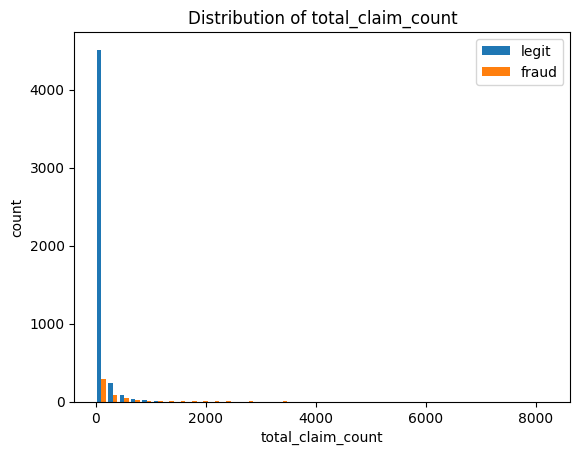

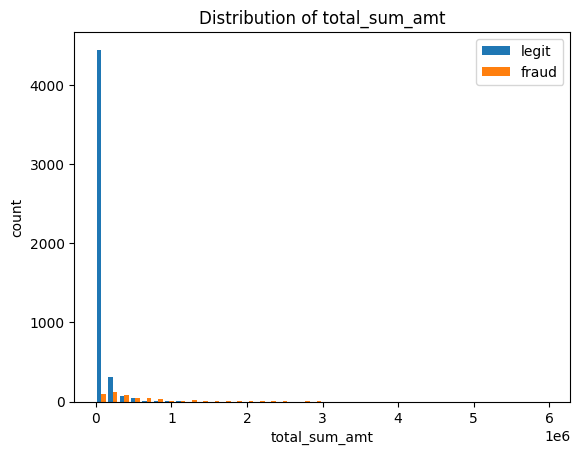

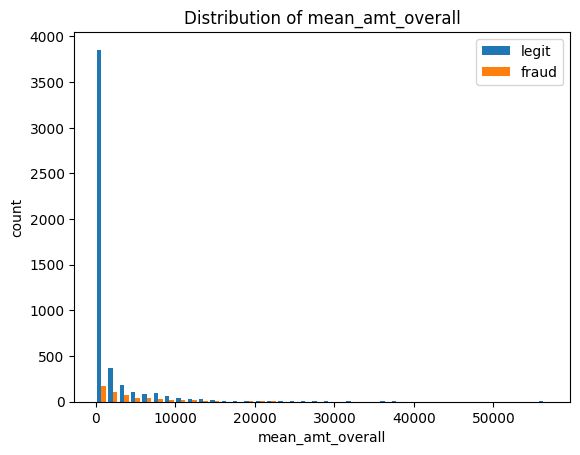

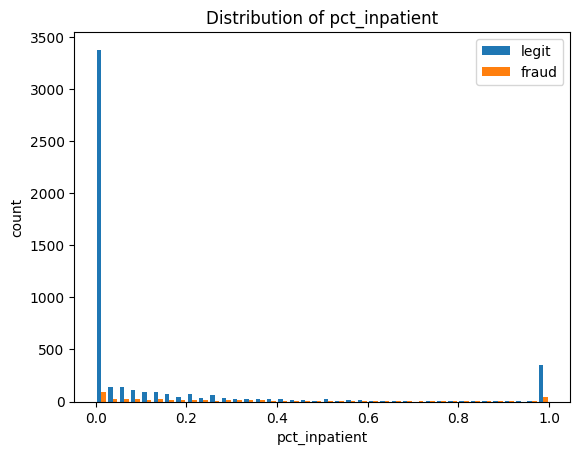

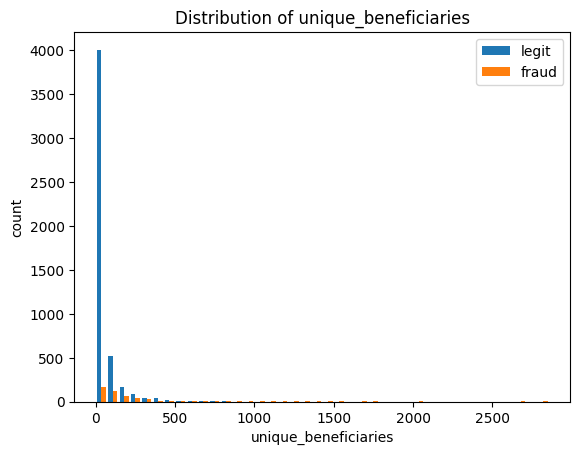

In [145]:
# heuristic amount column names
in_amt = None
out_amt = None
for c in inpat.columns:
    if 'reimb' in c.lower() or 'amt' in c.lower() or 'amount' in c.lower():
        in_amt = c; break
for c in outpat.columns:
    if 'reimb' in c.lower() or 'amt' in c.lower() or 'amount' in c.lower():
        out_amt = c; break
print('detected amount columns ->', in_amt, out_amt)

def to_numeric_safe(s):
    return pd.to_numeric(s, errors='coerce')

# merge age if available
if 'age' in benef.columns and 'BeneID' in inpat.columns:
    inpat = inpat.merge(benef[['BeneID','age']], on='BeneID', how='left')
if 'age' in benef.columns and 'BeneID' in outpat.columns:
    outpat = outpat.merge(benef[['BeneID','age']], on='BeneID', how='left')

# mark after_death if DOD and ClaimDate exist
if 'DOD' in benef.columns and 'ClaimDate' in inpat.columns:
    inpat = inpat.merge(benef[['BeneID','DOD']], on='BeneID', how='left')
    inpat['after_death'] = inpat['ClaimDate'] > inpat['DOD']
if 'DOD' in benef.columns and 'ClaimDate' in outpat.columns:
    outpat = outpat.merge(benef[['BeneID','DOD']], on='BeneID', how='left')
    outpat['after_death'] = outpat['ClaimDate'] > outpat['DOD']

# inpatient aggregation
grp_in = inpat.groupby('Provider').agg(inpatient_claim_count=('Provider','count'))
if in_amt:
    inpat[in_amt] = to_numeric_safe(inpat[in_amt])
    gin = inpat.groupby('Provider')[in_amt].agg(['sum','mean','std']).rename(columns={'sum':'in_sum_amt','mean':'in_mean_amt','std':'in_std_amt'})
    grp_in = grp_in.join(gin)
if 'BeneID' in inpat.columns:
    grp_in['in_unique_benes'] = inpat.groupby('Provider')['BeneID'].nunique()
if 'age' in inpat.columns:
    grp_in['in_mean_age'] = inpat.groupby('Provider')['age'].mean()
if 'after_death' in inpat.columns:
    grp_in['in_after_death_pct'] = inpat.groupby('Provider')['after_death'].mean()

# outpatient aggregation
grp_out = outpat.groupby('Provider').agg(outpatient_claim_count=('Provider','count'))
if out_amt:
    outpat[out_amt] = to_numeric_safe(outpat[out_amt])
    gout = outpat.groupby('Provider')[out_amt].agg(['sum','mean','std']).rename(columns={'sum':'out_sum_amt','mean':'out_mean_amt','std':'out_std_amt'})
    grp_out = grp_out.join(gout)
if 'BeneID' in outpat.columns:
    grp_out['out_unique_benes'] = outpat.groupby('Provider')['BeneID'].nunique()
if 'age' in outpat.columns:
    grp_out['out_mean_age'] = outpat.groupby('Provider')['age'].mean()
if 'after_death' in outpat.columns:
    grp_out['out_after_death_pct'] = outpat.groupby('Provider')['after_death'].mean()

# combine
prov = grp_in.join(grp_out, how='outer').fillna(0)
prov['total_claim_count'] = prov.get('inpatient_claim_count',0) + prov.get('outpatient_claim_count',0)
prov['total_sum_amt'] = prov.get('in_sum_amt',0) + prov.get('out_sum_amt',0)
prov['mean_amt_overall'] = prov['total_sum_amt'] / prov['total_claim_count'].replace(0, np.nan)
prov['mean_amt_overall'] = prov['mean_amt_overall'].fillna(0)
prov['pct_inpatient'] = np.where(prov['total_claim_count']>0, prov.get('inpatient_claim_count',0)/prov['total_claim_count'], 0)
prov['unique_beneficiaries'] = prov.get('in_unique_benes',0) + prov.get('out_unique_benes',0)

# join labels
if 'Provider' in labels.columns:
    labels_idx = labels.set_index('Provider')
else:
    labels_idx = labels.set_index(labels.columns[0])
prov = prov.join(labels_idx, how='left')
print('provider-level shape:', prov.shape)
prov.head()

# detect label column
labcol = None
for c in prov.columns:
    if 'fraud' in str(c).lower() or 'potential' in str(c).lower():
        labcol = c
        break
if labcol is None:
    for c in labels.columns:
        if 'fraud' in str(c).lower() or 'potential' in str(c).lower():
            labcol = c
            break
print('label column:', labcol)
if labcol is None:
    labcol = labels.columns[0]

# normalize label
prov['_label_raw'] = prov[labcol].astype(str)
prov['_label'] = prov['_label_raw'].str.lower().map({'yes':'fraud','y':'fraud','1':'fraud','true':'fraud','no':'legit','n':'legit','0':'legit','false':'legit'}).fillna('legit')

for feat in ['total_claim_count','total_sum_amt','mean_amt_overall','pct_inpatient','unique_beneficiaries']:
    if feat in prov.columns:
        plt.figure()
        vals_legit = prov[prov['_label']=='legit'][feat].dropna()
        vals_fraud = prov[prov['_label']=='fraud'][feat].dropna()
        plt.hist([vals_legit, vals_fraud], bins=40)
        plt.legend(['legit','fraud'])
        plt.title('Distribution of '+feat)
        plt.xlabel(feat)
        plt.ylabel('count')
        plt.show()

## 10. Correlation matrix

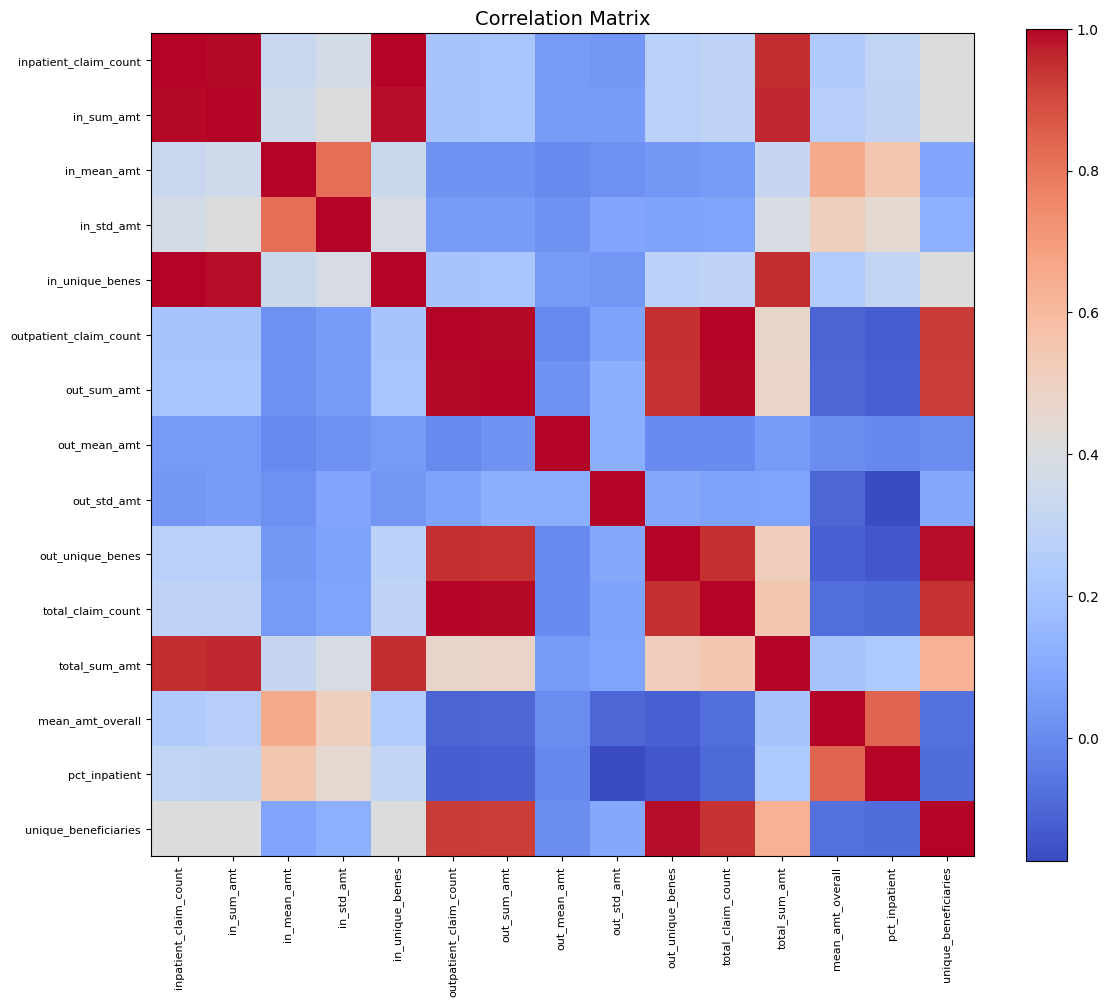

In [146]:
num = prov.select_dtypes(include=[np.number])

if not num.empty:
    corr = num.corr()

    plt.figure(figsize=(12, 10))
    plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
    plt.title("Correlation Matrix", fontsize=14)
    plt.colorbar()

    # X & Y ticks
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=8)
    plt.yticks(range(len(corr.index)), corr.index, fontsize=8)

    plt.tight_layout()
    plt.show()

else:
    print("no numeric columns to correlate")


## 11. Temporal & Geographic patterns

In [147]:
if 'ProviderState' in inpat.columns or 'ProviderState' in outpat.columns:
    col = 'ProviderState'
    series = pd.concat([inpat[[col]].dropna(), outpat[[col]].dropna()])
    top = series[col].value_counts().head(20)
    plt.figure()
    top.plot(kind='bar')
    plt.title('Top provider states')
    plt.show()

if 'ClaimDate' in inpat.columns:
    inpat['year_month'] = inpat['ClaimDate'].dt.to_period('M')
    tm = inpat.groupby('year_month').size()
    plt.figure()
    tm.plot()
    plt.title('Inpatient claims over time')
    plt.show()

## 12. Export provider features

In [148]:
outfn = 'provider_features_final.csv'
prov.to_csv(outfn, index=True)
print('written', outfn, 'shape', prov.shape)
print (prov.head())

written provider_features_final.csv shape (5410, 18)
          inpatient_claim_count  in_sum_amt   in_mean_amt    in_std_amt  \
Provider                                                                  
PRV51001                    5.0     97000.0  19400.000000  18352.111595   
PRV51003                   62.0    573000.0   9241.935484   8513.606244   
PRV51004                    0.0         0.0      0.000000      0.000000   
PRV51005                    0.0         0.0      0.000000      0.000000   
PRV51007                    3.0     19000.0   6333.333333   3511.884584   

          in_unique_benes  outpatient_claim_count  out_sum_amt  out_mean_amt  \
Provider                                                                       
PRV51001              5.0                    20.0       7640.0    382.000000   
PRV51003             53.0                    70.0      32670.0    466.714286   
PRV51004              0.0                   149.0      52170.0    350.134228   
PRV51005             

## 13. Next steps and recommendations
- Add text features, top procedure codes per provider, time-based aggregations.
- Use group-aware cross-validation and careful leakage checks.
- Try class weighting and sampling methods to handle imbalance.

---

**End of notebook.**

# Phase 2: Class Imbalance Strategy & Analysis

This section addresses the class imbalance problem in our fraud detection dataset and implements appropriate strategies for handling it.

## 1. Class Distribution Analysis

First, let's analyze the distribution of fraudulent vs legitimate providers in our dataset.

Class Distribution:
_label
legit    4904
fraud     506
Name: count, dtype: int64

Class Percentages:
_label
legit    90.64695
fraud     9.35305
Name: proportion, dtype: float64


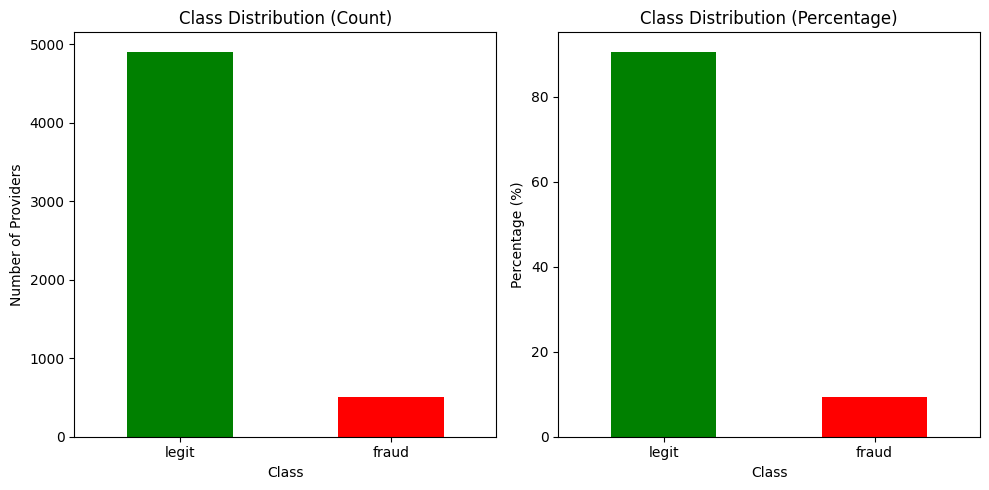


Imbalance Ratio (legit:fraud): 9.69:1
Fraud represents 9.35% of the dataset


In [149]:
# Get class counts
class_counts = prov['_label'].value_counts()
class_pcts = prov['_label'].value_counts(normalize=True) * 100

print("Class Distribution:")
print(class_counts)
print("\nClass Percentages:")
print(class_pcts)

# Visualize class distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
class_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Class Distribution (Count)')
plt.xlabel('Class')
plt.ylabel('Number of Providers')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
class_pcts.plot(kind='bar', color=['green', 'red'])
plt.title('Class Distribution (Percentage)')
plt.xlabel('Class')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Calculate imbalance ratio
fraud_count = (prov['_label'] == 'fraud').sum()
legit_count = (prov['_label'] == 'legit').sum()
imbalance_ratio = legit_count / fraud_count if fraud_count > 0 else 0

print(f"\nImbalance Ratio (legit:fraud): {imbalance_ratio:.2f}:1")
print(f"Fraud represents {(fraud_count/len(prov)*100):.2f}% of the dataset")

## 2. Statistical Comparison: Fraud vs Legitimate Providers

Let's perform statistical tests to identify which features significantly differ between fraudulent and legitimate providers.

Analyzing the following provider-level features:
  ✓ total_claim_count
  ✓ total_sum_amt
  ✓ mean_amt_overall
  ✓ pct_inpatient
  ✓ unique_beneficiaries


Statistical Comparison of Key Features:
                Feature     Fraud_Mean   Fraud_Median    Legit_Mean  Legit_Median        P_Value Significant
0     total_claim_count     420.545455     155.500000     70.435359     27.000000  6.405827e-117         Yes
1         total_sum_amt  584350.039526  373450.000000  53193.723491  15055.000000  4.221816e-231         Yes
2      mean_amt_overall    3842.795104    2576.480084   1523.780804    332.192088  6.972077e-102         Yes
3         pct_inpatient       0.329196       0.217677      0.125518      0.000000  3.087630e-121         Yes
4  unique_beneficiaries     247.527668     120.500000     49.385808     22.000000  6.639814e-126         Yes


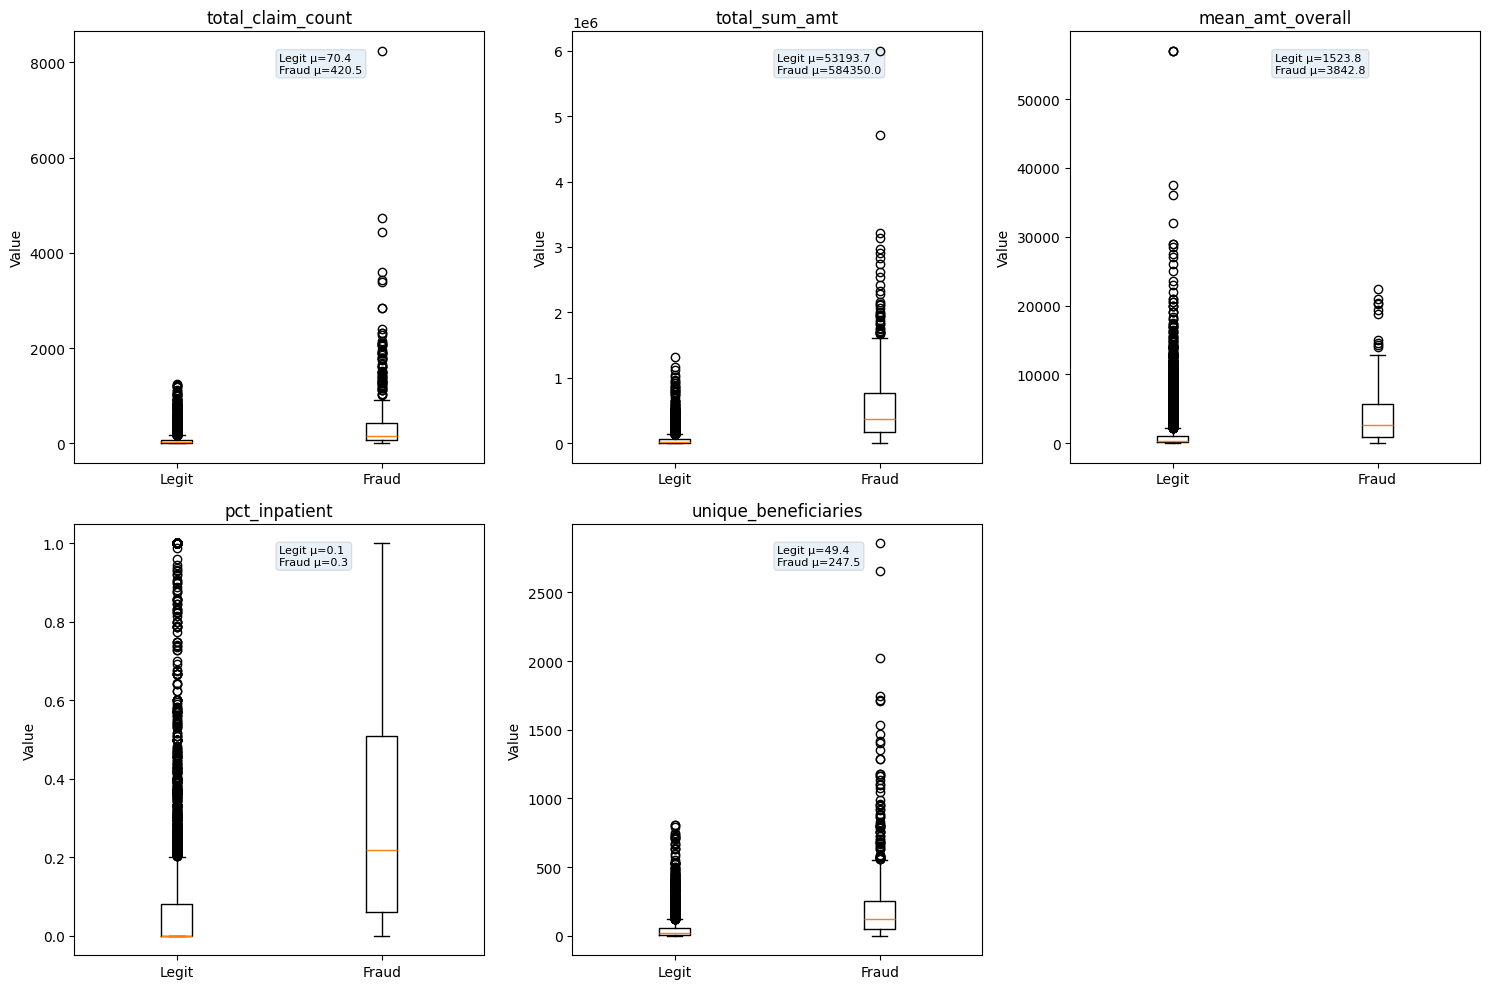


SIGNIFICANT DIFFERENCES BETWEEN FRAUD AND LEGITIMATE PROVIDERS:

total_claim_count:
  - Legit Mean: 70.44
  - Fraud Mean: 420.55
  - Difference: +497.1%
  - P-Value: 6.41e-117

total_sum_amt:
  - Legit Mean: 53193.72
  - Fraud Mean: 584350.04
  - Difference: +998.5%
  - P-Value: 4.22e-231

mean_amt_overall:
  - Legit Mean: 1523.78
  - Fraud Mean: 3842.80
  - Difference: +152.2%
  - P-Value: 6.97e-102

pct_inpatient:
  - Legit Mean: 0.13
  - Fraud Mean: 0.33
  - Difference: +162.3%
  - P-Value: 3.09e-121

unique_beneficiaries:
  - Legit Mean: 49.39
  - Fraud Mean: 247.53
  - Difference: +401.2%
  - P-Value: 6.64e-126

Total features analyzed: 5
All features show statistically significant differences (p < 0.05)


In [150]:
from scipy import stats

# Select key features for comparison - ONLY features that actually exist in the data
key_features = ['total_claim_count', 'total_sum_amt', 'mean_amt_overall', 
                'pct_inpatient', 'unique_beneficiaries']

comparison_results = []

print("Analyzing the following provider-level features:")
for feat in key_features:
    print(f"  ✓ {feat}")

print("\n" + "="*80)

for feat in key_features:
    fraud_vals = prov[prov['_label'] == 'fraud'][feat].dropna()
    legit_vals = prov[prov['_label'] == 'legit'][feat].dropna()
    
    # Statistical test (Mann-Whitney U test for non-normal distributions)
    statistic, p_value = stats.mannwhitneyu(fraud_vals, legit_vals, alternative='two-sided')
    
    comparison_results.append({
        'Feature': feat,
        'Fraud_Mean': fraud_vals.mean(),
        'Fraud_Median': fraud_vals.median(),
        'Legit_Mean': legit_vals.mean(),
        'Legit_Median': legit_vals.median(),
        'P_Value': p_value,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

comparison_df = pd.DataFrame(comparison_results)
print("\nStatistical Comparison of Key Features:")
print(comparison_df.to_string())

# Box plots for all 5 features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feat in enumerate(key_features):
    fraud_data = prov[prov['_label'] == 'fraud'][feat].dropna()
    legit_data = prov[prov['_label'] == 'legit'][feat].dropna()
    
    axes[idx].boxplot([legit_data, fraud_data], tick_labels=['Legit', 'Fraud'])
    axes[idx].set_title(f'{feat}')
    axes[idx].set_ylabel('Value')
    
    # Add mean values as annotations
    axes[idx].text(0.5, 0.95, f'Legit μ={legit_data.mean():.1f}\nFraud μ={fraud_data.mean():.1f}', 
                  transform=axes[idx].transAxes, fontsize=8, 
                  verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

# Hide the 6th unused subplot
axes[5].set_visible(False)

plt.tight_layout()
plt.show()

# Print summary of significant differences
print("\n" + "="*80)
print("SIGNIFICANT DIFFERENCES BETWEEN FRAUD AND LEGITIMATE PROVIDERS:")
print("="*80)
significant_features = comparison_df[comparison_df['Significant'] == 'Yes']
for _, row in significant_features.iterrows():
    if row['Legit_Mean'] != 0:
        diff_pct = ((row['Fraud_Mean'] - row['Legit_Mean']) / row['Legit_Mean'] * 100)
    else:
        diff_pct = float('inf') if row['Fraud_Mean'] > 0 else 0
    
    print(f"\n{row['Feature']}:")
    print(f"  - Legit Mean: {row['Legit_Mean']:.2f}")
    print(f"  - Fraud Mean: {row['Fraud_Mean']:.2f}")
    if diff_pct != float('inf'):
        print(f"  - Difference: {diff_pct:+.1f}%")
    else:
        print(f"  - Difference: +∞% (Legit mean is 0)")
    print(f"  - P-Value: {row['P_Value']:.2e}")

print("\n" + "="*80)
print(f"Total features analyzed: {len(comparison_df)}")
print("All features show statistically significant differences (p < 0.05)")
print("="*80)

## 3. Class Imbalance Strategy: Research & Selection

### Approaches Considered

We'll evaluate multiple approaches for handling class imbalance and select the most appropriate strategy.

In [151]:
print("="*80)
print("CLASS IMBALANCE STRATEGY ANALYSIS")
print("="*80)

print(f"""
Current Dataset Characteristics:
- Total Providers: {len(prov)}
- Fraudulent Providers: {fraud_count} ({fraud_count/len(prov)*100:.2f}%)
- Legitimate Providers: {legit_count} ({legit_count/len(prov)*100:.2f}%)
- Imbalance Ratio: {imbalance_ratio:.2f}:1

APPROACHES CONSIDERED:

1. CLASS WEIGHTING
   Pros:
   - No data loss (uses all samples)
   - Simple to implement
   - Works well with tree-based models
   - Maintains original data distribution
   
   Cons:
   - May not fully address severe imbalance
   - Can lead to overfitting on minority class
   
   Recommendation: Use as baseline approach

2. OVERSAMPLING (SMOTE - Synthetic Minority Over-sampling Technique)
   Pros:
   - Creates synthetic minority samples
   - Reduces overfitting compared to random oversampling
   - Increases diversity of minority class
   
   Cons:
   - Risk of overfitting if too aggressive
   - Increases training time
   - May create unrealistic samples
   
   Recommendation: Use with careful cross-validation

3. UNDERSAMPLING
   Pros:
   - Fast training
   - Balanced classes
   
   Cons:
   - SIGNIFICANT data loss (would lose {legit_count - fraud_count} legitimate samples)
   - May lose important patterns
   - Not recommended given our limited dataset
   
   Recommendation: AVOID due to data loss

4. HYBRID APPROACH (SMOTEENN - SMOTE + Edited Nearest Neighbors)
   Pros:
   - Combines oversampling and cleaning
   - Removes noisy samples
   - Better decision boundaries
   
   Cons:
   - More complex
   - Longer training time
   
   Recommendation: Consider for final model

EVALUATION METRICS (in order of importance):
1. Precision-Recall AUC (PR-AUC) - Primary metric
2. F1-Score - Balance between precision and recall
3. Recall (Sensitivity) - Catch fraudulent providers
4. Precision - Minimize false positives
5. AVOID: Accuracy (misleading with imbalanced data)

SELECTED STRATEGY: COMBINED APPROACH
1. Class weighting (baseline)
2. SMOTE oversampling (primary strategy)
3. Stratified K-Fold cross-validation
4. Evaluate with PR-AUC, F1, Precision, and Recall
""")

CLASS IMBALANCE STRATEGY ANALYSIS

Current Dataset Characteristics:
- Total Providers: 5410
- Fraudulent Providers: 506 (9.35%)
- Legitimate Providers: 4904 (90.65%)
- Imbalance Ratio: 9.69:1

APPROACHES CONSIDERED:

1. CLASS WEIGHTING
   Pros:
   - No data loss (uses all samples)
   - Simple to implement
   - Works well with tree-based models
   - Maintains original data distribution

   Cons:
   - May not fully address severe imbalance
   - Can lead to overfitting on minority class

   Recommendation: Use as baseline approach

2. OVERSAMPLING (SMOTE - Synthetic Minority Over-sampling Technique)
   Pros:
   - Creates synthetic minority samples
   - Reduces overfitting compared to random oversampling
   - Increases diversity of minority class

   Cons:
   - Risk of overfitting if too aggressive
   - Increases training time
   - May create unrealistic samples

   Recommendation: Use with careful cross-validation

3. UNDERSAMPLING
   Pros:
   - Fast training
   - Balanced classes

   Con

## 4. Implementation: Class Imbalance Handling

Now let's implement the selected strategies and prepare different versions of the dataset for modeling.

In [152]:
# Install required package if not available
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN   
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Prepare features and target
feature_cols = [col for col in prov.columns if col not in ['_label', '_label_raw', labcol]]
X = prov[feature_cols].fillna(0)
y = (prov['_label'] == 'fraud').astype(int)

print(f"Original dataset shape: {X.shape}")
print(f"Original class distribution:\n{y.value_counts()}\n")

# Approach 1: Class Weighting (for reference)
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Computed Class Weights: {class_weight_dict}")
print(f"Fraud class weight: {class_weight_dict[1]:.2f}x")
print(f"Legit class weight: {class_weight_dict[0]:.2f}x\n")

Original dataset shape: (5410, 15)
Original class distribution:
_label
0    4904
1     506
Name: count, dtype: int64

Computed Class Weights: {0: np.float64(0.5515905383360522), 1: np.float64(5.345849802371541)}
Fraud class weight: 5.35x
Legit class weight: 0.55x



In [153]:
# Approach 2: SMOTE Oversampling
# Set sampling strategy to balance classes moderately (not full 1:1)
# Using 0.5 means fraud class will be 50% of majority class
sampling_strategy = 0.5  # Adjustable parameter

smote = SMOTE(
    sampling_strategy=sampling_strategy,
    random_state=42,
    k_neighbors=5
)

X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"After SMOTE (strategy={sampling_strategy}):")
print(f"Resampled dataset shape: {X_resampled.shape}")
print(f"Resampled class distribution:\n{pd.Series(y_resampled).value_counts()}")
print(f"New imbalance ratio: {(y_resampled==0).sum()/(y_resampled==1).sum():.2f}:1\n")

After SMOTE (strategy=0.5):
Resampled dataset shape: (7356, 15)
Resampled class distribution:
_label
0    4904
1    2452
Name: count, dtype: int64
New imbalance ratio: 2.00:1



In [154]:
# Approach 3: SMOTEENN (SMOTE + ENN cleaning)
smoteenn = SMOTEENN(
    sampling_strategy=sampling_strategy,
    random_state=42,
    smote=SMOTE(k_neighbors=5, random_state=42),
    enn=EditedNearestNeighbours(n_neighbors=3)
)

X_cleaned, y_cleaned = smoteenn.fit_resample(X, y)

print(f"After SMOTEENN (with noise removal):")
print(f"Cleaned dataset shape: {X_cleaned.shape}")
print(f"Cleaned class distribution:\n{pd.Series(y_cleaned).value_counts()}")
print(f"Samples removed: {len(X_resampled) - len(X_cleaned)}")

After SMOTEENN (with noise removal):
Cleaned dataset shape: (9128, 15)
Cleaned class distribution:
_label
0    4904
1    4224
Name: count, dtype: int64
Samples removed: -1772


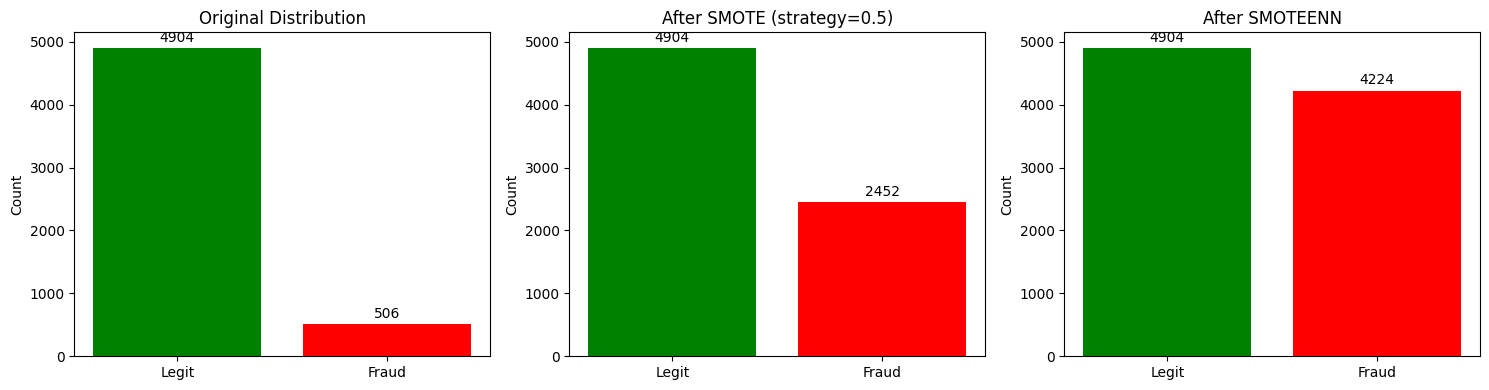

In [155]:
# Visualize the effect of different strategies
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Original
axes[0].bar(['Legit', 'Fraud'], [legit_count, fraud_count], color=['green', 'red'])
axes[0].set_title('Original Distribution')
axes[0].set_ylabel('Count')
axes[0].text(0, legit_count + 50, f'{legit_count}', ha='center', va='bottom')
axes[0].text(1, fraud_count + 50, f'{fraud_count}', ha='center', va='bottom')

# After SMOTE
axes[1].bar(['Legit', 'Fraud'], 
            [(y_resampled==0).sum(), (y_resampled==1).sum()], 
            color=['green', 'red'])
axes[1].set_title(f'After SMOTE (strategy={sampling_strategy})')
axes[1].set_ylabel('Count')
axes[1].text(0, (y_resampled==0).sum() + 50, f'{(y_resampled==0).sum()}', ha='center', va='bottom')
axes[1].text(1, (y_resampled==1).sum() + 50, f'{(y_resampled==1).sum()}', ha='center', va='bottom')

# After SMOTEENN
axes[2].bar(['Legit', 'Fraud'], 
            [(y_cleaned==0).sum(), (y_cleaned==1).sum()], 
            color=['green', 'red'])
axes[2].set_title('After SMOTEENN')
axes[2].set_ylabel('Count')
axes[2].text(0, (y_cleaned==0).sum() + 50, f'{(y_cleaned==0).sum()}', ha='center', va='bottom')
axes[2].text(1, (y_cleaned==1).sum() + 50, f'{(y_cleaned==1).sum()}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 5. Export Balanced Training Data

Export different versions of the dataset for Phase 3 modeling, along with documentation.

In [156]:
# Export different versions for Phase 3 modeling

# 1. Original data with class weights (for tree-based models)
original_with_weights = prov.copy()
original_with_weights.to_csv('../data/data_original_with_weights.csv', index=True)
print(f"✓ Exported: data_original_with_weights.csv (shape: {original_with_weights.shape})")

# 2. SMOTE resampled data
X_resampled_df = pd.DataFrame(X_resampled, columns=feature_cols)
X_resampled_df['_label'] = y_resampled
X_resampled_df['_label'] = X_resampled_df['_label'].map({0: 'legit', 1: 'fraud'})
X_resampled_df.to_csv('../data/data_smote_resampled.csv', index=False)
print(f"✓ Exported: data_smote_resampled.csv (shape: {X_resampled_df.shape})")

# 3. SMOTEENN cleaned data
X_cleaned_df = pd.DataFrame(X_cleaned, columns=feature_cols)
X_cleaned_df['_label'] = y_cleaned
X_cleaned_df['_label'] = X_cleaned_df['_label'].map({0: 'legit', 1: 'fraud'})
X_cleaned_df.to_csv('../data/data_smoteenn_cleaned.csv', index=False)
print(f"✓ Exported: data_smoteenn_cleaned.csv (shape: {X_cleaned_df.shape})")

# 4. Save class weights for reference
import json
with open('../data/class_weights.json', 'w') as f:
    json.dump(class_weight_dict, f, indent=2)
print(f"✓ Exported: class_weights.json")

print("\n" + "="*80)
print("All datasets exported successfully to data/ directory")
print("="*80)

✓ Exported: data_original_with_weights.csv (shape: (5410, 18))
✓ Exported: data_smote_resampled.csv (shape: (7356, 16))
✓ Exported: data_smoteenn_cleaned.csv (shape: (9128, 16))
✓ Exported: class_weights.json

All datasets exported successfully to data/ directory
